In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 48
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 20

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "FacialEmotion",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 35887 files belonging to 7 classes.


In [5]:
class_names = dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
len(dataset)

561

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 48, 48, 3)
[0 3 3 3 0 4 3 4 6 2 0 6 5 0 5 4 2 3 5 4 3 3 1 6 5 0 2 5 5 3 0 0 4 2 3 3 6
 0 1 3 1 2 0 5 3 5 3 6 6 5 5 4 3 5 3 4 6 4 0 3 6 4 5 3]


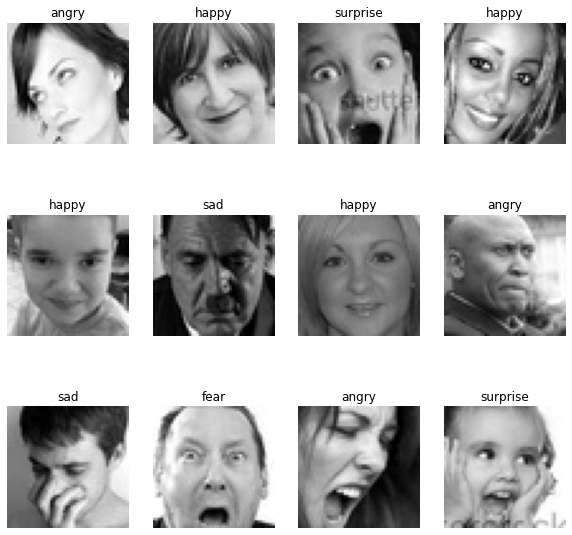

In [8]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## 80% ==> train
## 20% ==> 10% ==> validation, 10% ==> test

In [9]:
train_size = 0.8
len(dataset)*train_size

448.8

In [10]:
train_ds = dataset.take(448)
len(train_ds)

448

In [11]:
test_ds = dataset.skip(448)
len(test_ds)

113

In [12]:
val_size = 0.1
len(dataset)*val_size

56.1

In [13]:
val_ds = test_ds.take(56)

In [14]:
len(val_ds)

56

In [15]:
test_ds = test_ds.skip(56)
len(test_ds)

57

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)     # all this is to improve the performacne
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)    
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)  

In [17]:
# lets do some preprocessing

In [18]:
'''
These layers are for preprocessing and we will use it later while model building. One is to resize the image and other divides
the size of 48 by 47 to get a number between 0 and 1
'''
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/47)
])

In [19]:
'''
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
'''
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
# model building

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 48, 48, 3)           0         
                                                                 
 conv2d (Conv2D)             (64, 46, 46, 32)          896       
                                                                 
 conv2d_1 (Conv2D)           (64, 44, 44, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (64, 42, 42, 64)          36928     
                                                                 
 conv2d_3 (Conv2D)           (64, 40, 40, 64)          36928     
                                                                 
 max_pooling2d (MaxPooling2D  (64, 20, 20, 64)         0         
 )                                                               
                                                      

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
448/448 [==============================] - 282s 618ms/step - loss: 1.7874 - accuracy: 0.2680 - val_loss: 1.6633 - val_accuracy: 0.3474
Epoch 2/20
448/448 [==============================] - 267s 597ms/step - loss: 1.4994 - accuracy: 0.4172 - val_loss: 1.3568 - val_accuracy: 0.4760
Epoch 3/20
448/448 [==============================] - 415s 928ms/step - loss: 1.3025 - accuracy: 0.5021 - val_loss: 1.2741 - val_accuracy: 0.5089
Epoch 4/20
448/448 [==============================] - 317s 707ms/step - loss: 1.2069 - accuracy: 0.5402 - val_loss: 1.2163 - val_accuracy: 0.5368
Epoch 5/20
448/448 [==============================] - 303s 676ms/step - loss: 1.1286 - accuracy: 0.5701 - val_loss: 1.2082 - val_accuracy: 0.5399
Epoch 6/20
448/448 [==============================] - 329s 735ms/step - loss: 1.0682 - accuracy: 0.5961 - val_loss: 1.1963 - val_accuracy: 0.5547
Epoch 7/20
448/448 [==============================] - 276s 615ms/step - loss: 1.0027 - accuracy: 0.6206 - val_loss: 1.2055 -

In [25]:
scores = model.evaluate(test_ds)

57/57 [==============================] - 37s 131ms/step - loss: 2.4344 - accuracy: 0.5456


In [26]:
scores

[2.4343793392181396, 0.545579731464386]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 448}

In [29]:
history.history

{'loss': [1.7874135971069336,
  1.4993966817855835,
  1.3025070428848267,
  1.2069119215011597,
  1.1286197900772095,
  1.0682297945022583,
  1.0027048587799072,
  0.9310044646263123,
  0.8710883855819702,
  0.8046914339065552,
  0.7335963249206543,
  0.6806588172912598,
  0.6105878949165344,
  0.5597012042999268,
  0.49292200803756714,
  0.44110652804374695,
  0.40009835362434387,
  0.3571572005748749,
  0.3338134288787842,
  0.3044663369655609],
 'accuracy': [0.2679617702960968,
  0.4171665608882904,
  0.5020577311515808,
  0.5401785969734192,
  0.570068359375,
  0.5961216688156128,
  0.6205706000328064,
  0.6507045030593872,
  0.6745256781578064,
  0.699462890625,
  0.7244698405265808,
  0.7446986436843872,
  0.7743791937828064,
  0.7925850749015808,
  0.8175920844078064,
  0.8360072374343872,
  0.8515276312828064,
  0.8663853406906128,
  0.8780342936515808,
  0.8886370062828064],
 'val_loss': [1.6632617712020874,
  1.356820821762085,
  1.274051308631897,
  1.2162532806396484,
  1.2

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

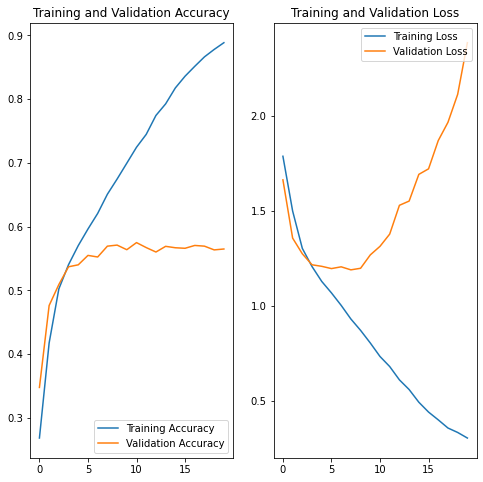

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: neutral
predicted label: neutral


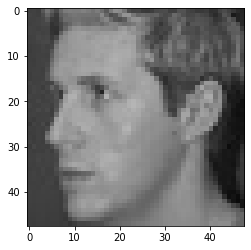

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

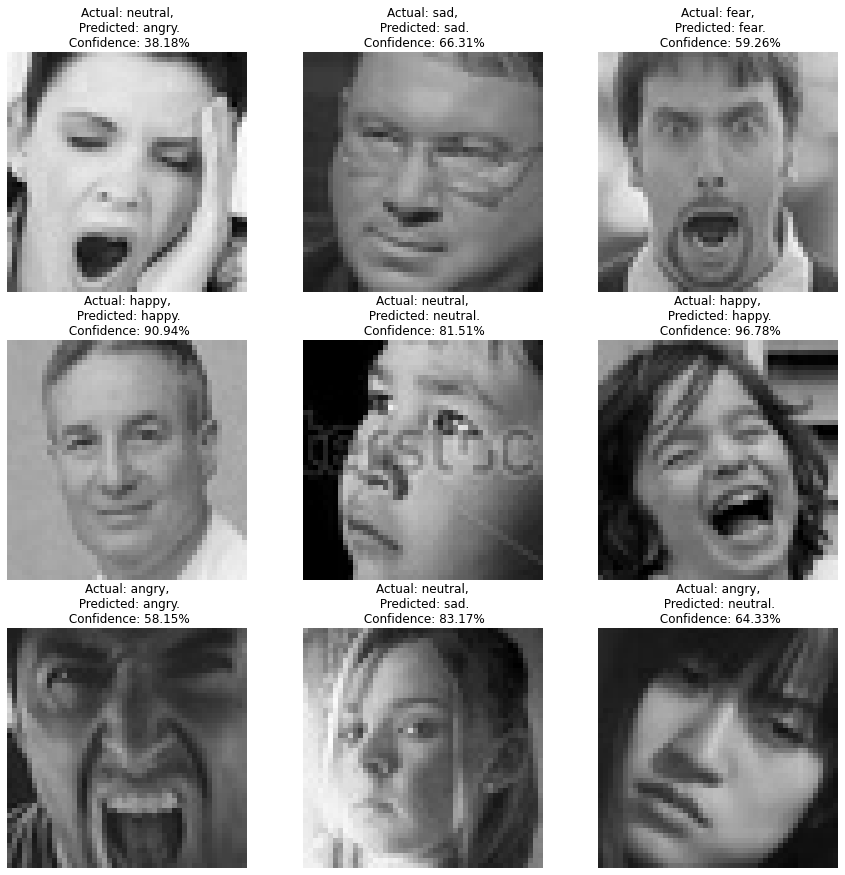

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [37]:
model.save("../fer_1.h5")